# Importing Libraries


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
from fastai.callback import schedule
from fastai.metrics import mse
import time
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core


# Loading the Dataset

In [2]:
data1 = pd.read_csv('data.csv', header=None)
data1 = data1.fillna('0;0')

# Removing the useless columns and adding column names

In [3]:
orig = data1
data1 = data1[[0,1,2,3,4]]
data2 = pd.DataFrame(data1[4].str.split(';').tolist(), columns = ['phi1', 'obj2'])
data1 = pd.concat([data1[[0,1,2,3]], data2], axis=1, join="inner")

In [4]:
data2 = pd.DataFrame(data1[0].str.split(';').tolist(), columns = ['event ID', 'process ID', 'event weight', 'MET', 'METphi','obj1'])
data1 = pd.concat([data2,data1[[1,2,3,'phi1']]], axis=1, join="inner")

In [5]:
data1.columns = ['event ID',   'process ID', 'event weight',          'MET',
             'METphi',         'obj',              'E', 'pt', 'eta',         'phi']
final = data1[['obj','E', 'pt', 'eta','phi']]

In [6]:
final

,obj,E,pt,eta,phi
0,b,947383.0,824498.0,-0.523103,1.64421
1,j,1070000.0,751597.0,0.858186,-1.84217
2,j,676000.0,640429.0,0.330450,0.704554
3,j,936707.0,616229.0,0.973383,-1.56592
4,j,640313.0,589524.0,0.390749,1.23734
...,...,...,...,...,...
6394,j,1120000.0,1010000.0,0.453265,-1.77278
6395,j,1920000.0,874869.0,1.418550,1.83927
6396,j,787964.0,263158.0,1.759810,0.456786
6397,j,731849.0,722541.0,-0.134499,2.56393


Collects all other objects after obj1 and adds them to the final dataset

In [7]:
for i in range(4,48,4):
    data_4  = orig[[i,i+1,i+2,i+3,i+4]]
    temp = pd.DataFrame(data_4[i].str.split(';').tolist(), columns = ['phi1', 'obj2'])
    temp2 = pd.DataFrame(data_4[i+4].str.split(';').tolist(), columns = ['phi2', 'obj3'])
    temp = pd.concat([temp['obj2'],data_4[[i+1,i+2,i+3]]],axis=1, join="inner")
    data_4 = pd.concat([temp[['obj2',i+1,i+2,i+3]],temp2['phi2']],axis=1, join="inner")
    data_4.columns = ['obj','E', 'pt', 'eta','phi']
    final = pd.concat([final,data_4])
    final = final.reset_index(drop=True)

    
    

Select samples where the object is a jet particle

In [8]:
final = final[final['obj']=='j'][['E', 'pt', 'eta','phi']]

# Custom Normalization for the dataset

Adding custom normalization to make the max value of all varibles near one

In [9]:
def custom_normalize(df):
    df['eta'] = df['eta'] /5
    df['phi'] = df['phi'].astype(float) / 3
    df['E'] = np.log10(df['E'].astype(float)) /6
#     df['m'] = 10**df['m']
    df['pt'] = np.log10(df['pt'].astype(float)) /6
    return df

In [10]:
final = custom_normalize(final)

In [11]:
final.head()

,E,pt,eta,phi
1,1.004897,0.979331,0.171637,-0.614057
2,0.971658,0.967745,0.06609,0.234851
3,0.995267,0.964957,0.194677,-0.521973
4,0.967732,0.961750,0.07815,0.412447
5,0.960991,0.956163,0.072811,-0.535773


In [12]:
final.max()

E      1.107406
pt     1.053358
eta    0.950616
phi     1.04707
dtype: object

# Train test Split

In [13]:
train, test = train_test_split(final, test_size=0.2)

In [14]:
print('Training sample:')
print(train.head())

print('\n')

print('Testing sample:')
print(test.head())

print('\n')

print('The number of entries in the training data:', len(train))
print('The number of entries in the validation data:', len(test))

Training sample:
              E        pt       eta       phi
17060  0.964202  0.823562  -0.52614  0.157060
12110  0.970176  0.930268 -0.228386  0.905243
4725   0.984580  0.971988 -0.119382  0.086312
6715   0.941377  0.849537 -0.388126  0.806337
15673  0.896308  0.845572  0.263098 -0.246632


Testing sample:
              E        pt       eta       phi
23519  0.799438  0.741710  -0.28628 -0.417400
6738   0.922628  0.899788 -0.163778  0.741287
19097  1.047967  0.910035   0.51809 -0.264108
16504  0.899109  0.745637 -0.561808  0.320286
4114   0.961410  0.957133  0.063684 -0.474543


The number of entries in the training data: 18128
The number of entries in the validation data: 4533





# Lets have a closer look at the data

NOTE: The plots are of normalized data but we only care about the shape.

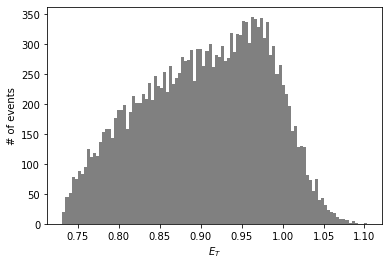

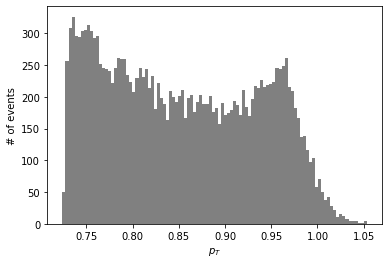

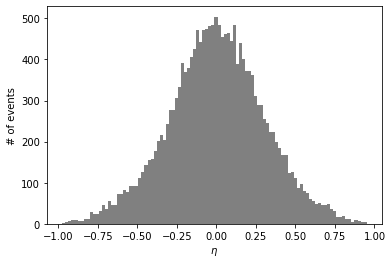

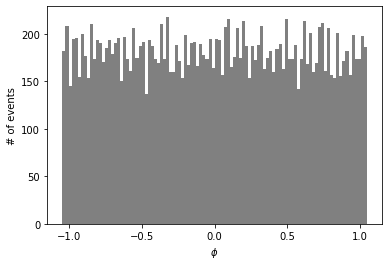

In [15]:

# unit_list = ['[log(GeV)]', '[rad/3]', '[rad/3]', '[log(GeV)]']
variable_list = [r'$E_T$',r'$p_T$', r'$\eta$', r'$\phi$']

branches=['E', 'pt', 'eta','phi']

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
#     plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.xlabel(xlabel=variable_list[kk])

    plt.ylabel('# of events')
    #plt.savefig("fourmomentum_"+branches[kk],dpi=300)
    plt.show()


# Setting up the network

## Preparing the data

In [16]:
train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(np.array(train_x.values, dtype=float), dtype=torch.float), torch.tensor(np.array(train_y.values, dtype=float), dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(np.array(test_x.values, dtype=float), dtype=torch.float), torch.tensor(np.array(test_y.values, dtype=float), dtype=torch.float))




In [17]:
bs = 16

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

## Preparing the network

I reduced the size of the network as the dataset provided here is of much less size. This network is performing quite well and uses much less computational resources

In [18]:
class AE_3D_Custom(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_Custom, self).__init__()
        self.en1 = nn.Linear(n_features, 3)
        self.de4 = nn.Linear(3, n_features)

    def encode(self, x):
        return self.en1(x)

    def decode(self, x):
        return self.de4(x)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_Custom()
model.to('cpu')

AE_3D_Custom(
  (en1): Linear(in_features=4, out_features=3, bias=True)
  (de4): Linear(in_features=3, out_features=4, bias=True)
)

## Initializing the loss function

MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize.

In [19]:

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

## Training the network from scratch

The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.13182567358016967
Learning rate with the steepest gradient: 0.10000000149011612


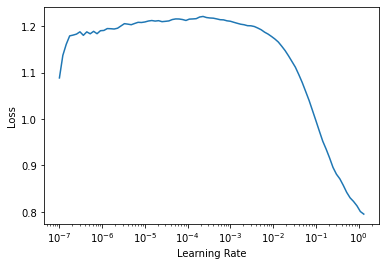

In [20]:

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [21]:

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(100,lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 0.00046188998385332525, 0.0004163069243077189, '00:03']
[0, 0.00046188998385332525, 0.0004163069243077189, '00:03']
[1, 0.0004318902501836419, 0.00040303298737853765, '00:02']
[1, 0.0004318902501836419, 0.00040303298737853765, '00:02']
[2, 0.00044214955414645374, 0.00042888877214863896, '00:02']
[2, 0.00044214955414645374, 0.00042888877214863896, '00:02']
[3, 0.0004445405793376267, 0.00040931819239631295, '00:02']
[3, 0.0004445405793376267, 0.00040931819239631295, '00:02']
[4, 0.0004466602113097906, 0.000488370074890554, '00:02']
[4, 0.0004466602113097906, 0.000488370074890554, '00:02']
[5, 0.00046555453445762396, 0.0004659518017433584, '00:02']
[5, 0.00046555453445762396, 0.0004659518017433584, '00:02']
[6, 0.0004971873131580651, 0.0004693249356932938, '00:02']
[6, 0.0004971873131580651, 0.0004693249356932938, '00:02']
[7, 0.0007129668956622481, 0.0006335002835839987, '00:02']
[7, 0.0007129668956622481, 0.0006335002835839987, '00:02']
[8, 0.0005245244828984141, 0.00042148752254433

plot the loss as a function of batches and epochs to check if we reach a plateau.

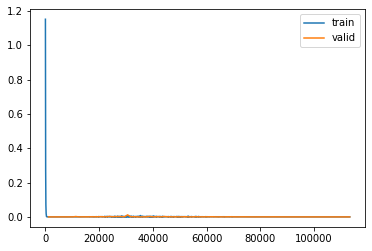

In [22]:
recorder.plot_loss()

In [23]:
learn.validate()

(#1) [0.0003844408201985061]

## Plotting the outputs of the network

In [24]:
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [25]:
def custom_unnormalize(df):
    df['eta'] = df['eta']*5
    df['phi'] = df['phi'] * 3
    df['E'] = (10**(df['E']*6))
#     df['m'] = 10**df['m']
    df['pt'] = (10**(df['pt']*6))
    return df

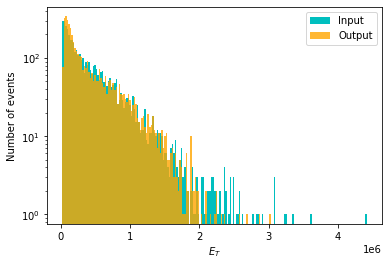

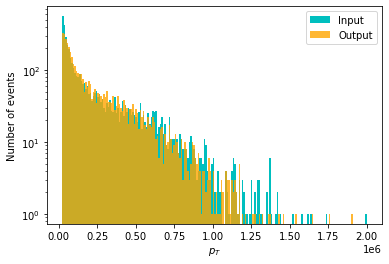

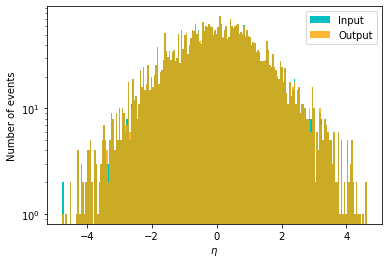

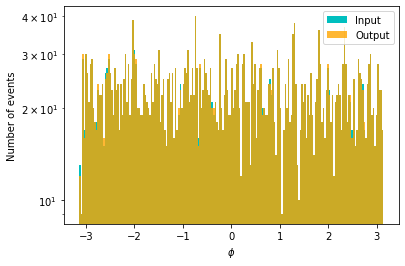

In [26]:


plt.close('all')
# unit_list = ['[log(GeV)]', '[rad/3]', '[rad/3]', '[log(GeV)]']
variable_list = [r'$E_T$',r'$p_T$', r'$\eta$', r'$\phi$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = True # Option to save figure

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(np.array(test[idxs[0]:idxs[1]].values,dtype=float), dtype=torch.float)

# data = torch.tensor(np.array(test[idxs[0]:idxs[1]].values,dtype=float), dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)    
    
alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
#     plt.suptitle(test.columns[kk])
    plt.xlabel(variable_list[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    plt.legend()
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    

In [27]:
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins   

rat = getRatio(n_hist_data,n_hist_pred)


In [28]:
print(rat)

[-0.07692307692307693, 0.0, 0.034482758620689655, -0.058823529411764705, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.05555555555555555, 0.043478260869565216, 0.0, 0.0, 0.0, 0.06666666666666667, -0.038461538461538464, -0.037037037037037035, 0.034482758620689655, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.03225806451612903, 0.03571428571428571, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05263157894736842, -0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0625, 0.037037037037037035, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.047619047619047616, 0.05263157894736842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.037037037037037035, -0.05, 0.0, 0.0, 0.0, 0.0, -0.04, 0.045454545454545456, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,